In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# CIFAR-10

In [2]:
import keras
import numpy as np
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Dataset

**CIFAR-10** [(Krizhevsky, 2009)](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf): 60000 32x32 colour images in 10 classes, with 6000 images per class (50000 training images and 10000 test images). Very widely used today for testing performance of new algorithms. This fast.ai datasets version uses a standard PNG format instead of the platform-specific binary formats of the original, so you can use the regular data pipelines in most libraries.

Lets download the dataset

In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz

--2019-09-08 16:58:19--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.10.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.10.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz.4’

100%[======================================>] 135,107,811 61.9MB/s   in 2.1s   

2019-09-08 16:58:21 (61.9 MB/s) - ‘cifar10.tgz.4’ saved [135107811/135107811]



And unzip

In [4]:
!tar -xf cifar10.tgz

The dataset is already in ImageNet folder format, i.e. each class has a directory that contains all the pictures belonging to that class

In [5]:
!ls cifar10/

test  train


In [6]:
!ls cifar10/train/

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


### Intro. to using Datagenerators 

In some cases of large datasets, even the most state-of-the-art configuration won't have enough memory space to hold all the data at the same time. Hence we need to find other ways to do the task of feeding batched of data into deep learning models efficiently.

Keras already has a native implementation of Image data generators that takes care of reading batches of data and feeding into Deep Neural Nets (see https://keras.io/preprocessing/image/). Addititionally the data generator implementation in keras has convenient functions for preprocessing of data such as rescaling, augmenting and whitening, etc. 

Additionally, we need to format our datat into appropriately pre-processed floating point tensors before feeding into our network. Currently, the data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

- Read the picture files.
- Decode the JPEG content to RBG grids of pixels.
- Convert these into floating point tensors.
- Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

It may seem a bit daunting, but thankfully the data generator implementation in keras has convenient functions for preprocessing of data such as rescaling, augmenting and whitening, etc. 

Lastly, the ImageDataGenerator in keras has an in-built method called `flow_from_directory` that exploits the ImageNet directory structure off the shelf.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255 
# For data Augmentation we intriduce zoom, shifts and random rotations.
train_datagen = ImageDataGenerator(rescale=1./255,
                                  fill_mode = "nearest",
                                  zoom_range = 0.3,
                                  width_shift_range = 0.3,
                                  height_shift_range=0.3,
                                  rotation_range=45)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        directory='cifar10/train/',
        # All images will be resized to 150x150
        target_size=(32, 32),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        directory='cifar10/test/',
        target_size=(32, 32),
        batch_size=32,
        class_mode='categorical')

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape (32, 150, 150, 3)) and categorical labels (shape (32,10)). 32 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to break the iteration loop at some point.

In [8]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 32, 32, 3)
labels batch shape: (32, 10)


### Visualize a sample of Training Data 

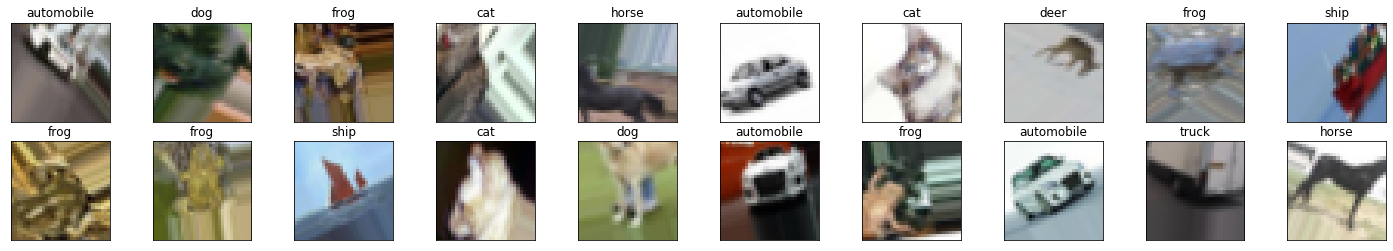

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
images, labels = train_generator.next()[:20]


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(np.argmax(labels[idx]))])

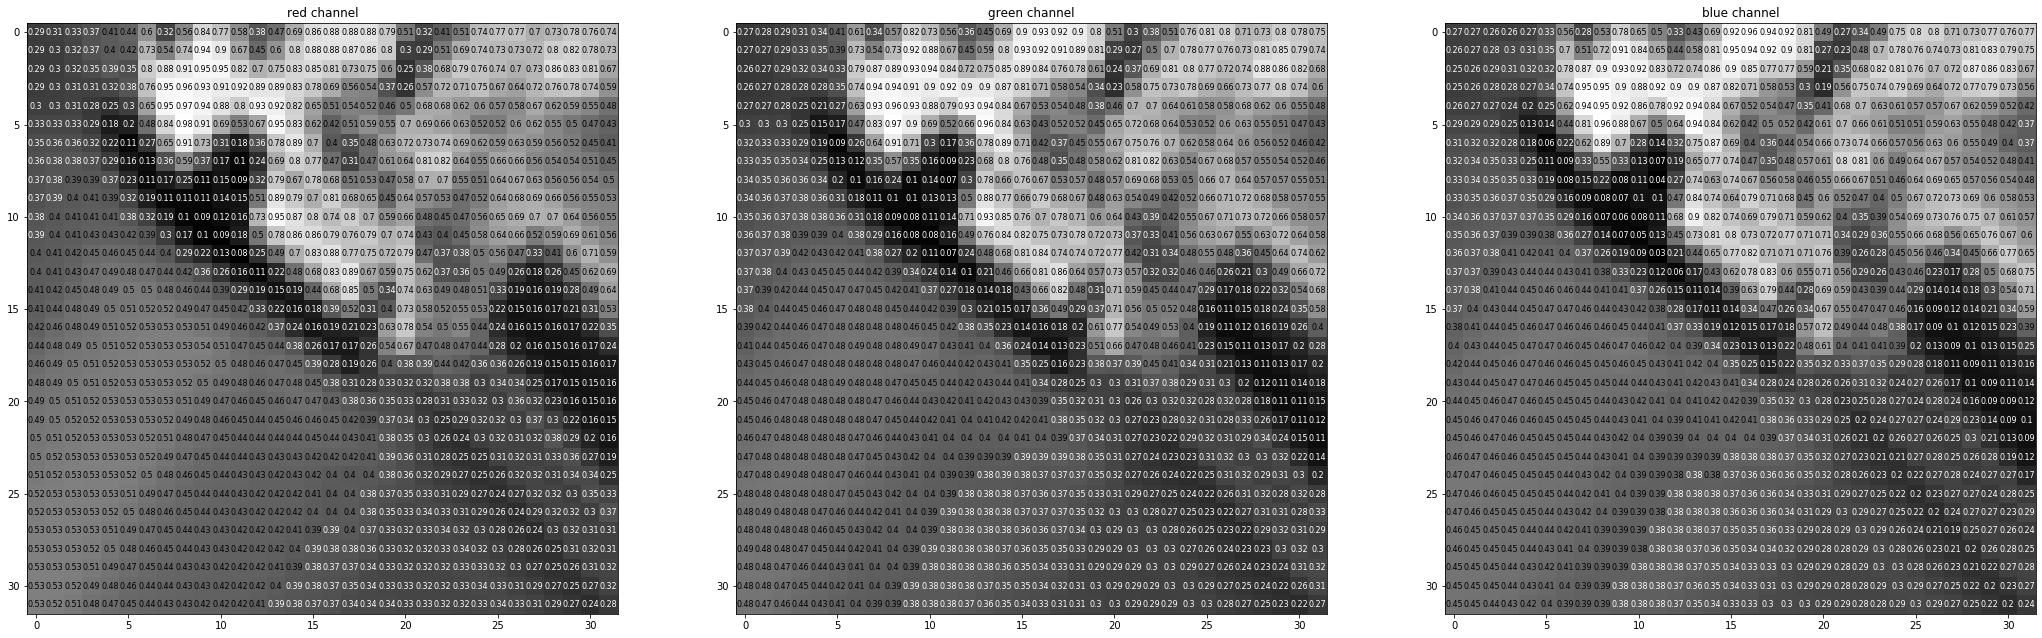

In [10]:
#images, labels = keras.datasets.cifar10.load_data()[0]

rgb_img = np.squeeze(images[0])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[-1]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[:,:,idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## Define the Network Architecture

The 6 lines of code below show you what a basic convnet looks like. It's a stack of Conv2D and MaxPooling2D layers. We'll see in a minute what they do concretely. Importantly, a convnet takes as input tensors of shape (image_height, image_width, image_channels) (not including the batch dimension). In our case, we will configure our convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. We do this via passing the argument input_shape=(28, 28, 1) to our first layer.

In [12]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of our convnet so far:

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to the Conv2D layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape (3, 3, 64)) into a densely-connected classifier network like those you are already familiar with: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. So first, we will have to flatten our 3D outputs to 1D, and then add a few Dense layers on top:

In [14]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network looks like:

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
__________

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576,), before going through two Dense layers.

Now, let's train our convnet on the CIFAR-10 dataset. 

## Compile and Train

In [17]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

The steps for training/learning from a batch of data are described in the comments below:

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Keras wraps up all of these steps in one function: `model.fit()`. In the following we train for 5 epochs with a batch size of 64. Notice how the loss decreases and accuracy increases as we train.

Let's fit our model to the data using the generator. We do it using the fit_generator method, the equivalent of fit for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 32-sample large, so it will take 1562 batches until we see our target of 50000 samples.

When using fit_generator, one may pass a validation_data argument, much like with the fit method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [18]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1562,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=312)

W0908 17:00:52.907390 140264859170624 deprecation.py:323] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0908 17:00:52.982225 140264859170624 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
1562/1562 [==============================] - 55s 35ms/step - loss: 1.9107 - acc: 0.2915 - val_loss: 1.6148 - val_acc: 0.4005
Epoch 2/30
1562/1562 [==============================] - 48s 31ms/step - loss: 1.7264 - acc: 0.3706 - val_loss: 1.4759 - val_acc: 0.4582
Epoch 3/30
1562/1562 [==============================] - 48s 31ms/step - loss: 1.6241 - acc: 0.4097 - val_loss: 1.4320 - val_acc: 0.4883
Epoch 4/30
1562/1562 [==============================] - 48s 31ms/step - loss: 1.5633 - acc: 0.4344 - val_loss: 1.4221 - val_acc: 0.4842
Epoch 5/30
1562/1562 [==============================] - 48s 31ms/step - loss: 1.5178 - acc: 0.4506 - val_loss: 1.3823 - val_acc: 0.4972
Epoch 6/30
1562/1562 [==============================] - 48s 31ms/step - loss: 1.4764 - acc: 0.4677 - val_loss: 1.2886 - val_acc: 0.5311
Epoch 7/30
1562/1562 [==============================] - 47s 30ms/step - loss: 1.4438 - acc: 0.4783 - val_loss: 1.3123 - val_acc: 0.5273
Epoch 8/30
1562/1562 [==========================

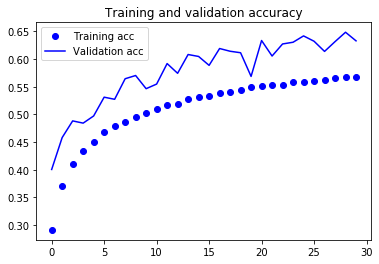

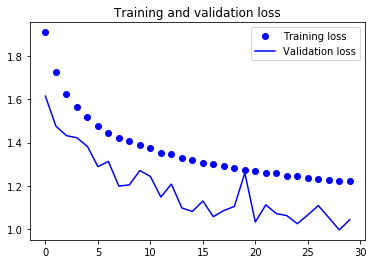

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Transfer Learning

In [20]:
from keras.applications.resnet50 import ResNet50
from keras import Model

In [21]:
base_model = ResNet50(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = base_model.get_layer('bn5b_branch2b').output
x = layers.Flatten()(x)
x = layers.Dense(124, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu", name='second_last_layer')(x)
predictions = layers.Dense(10, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.summary()

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0908 17:26:46.366820 140264859170624 deprecation_wrapper.py:119] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

/home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W0908 17:26:56.143357 140264859170624 deprecation.py:506] From /home/khan74/.conda/envs/gwsurr/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1562,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=312)

Epoch 1/1
1562/1562 [==============================] - 399s 256ms/step - loss: 2.1597 - acc: 0.1893 - val_loss: 2.3455 - val_acc: 0.0997


In [23]:
for layer in model.layers[:]: layer.trainable = True

model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=1562,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=312)

Epoch 1/3
 812/1562 [==============>...............] - ETA: 5:33 - loss: 2.1051 - acc: 0.1917

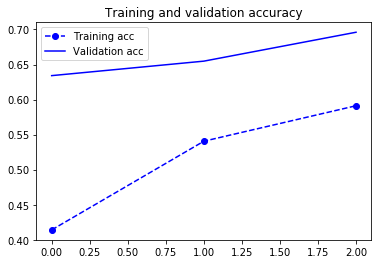

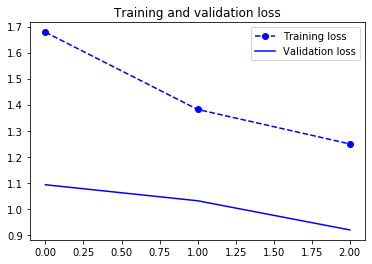

In [78]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '--bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()